In [2]:
#Setting up prerequisites
import pandas as pd
import numpy as np
import math
import re
import sklearn
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")
from sklearn.metrics import mean_squared_error

from numpy import matrix

print("Setup Complete\n")

Setup Complete



In [3]:
class MF():

    def __init__(self, R, K, alpha, beta, iterations,R_base):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.R_base=R_base

    def train(self):
        # Create and initialize P and Q matrices with random values
        
        self.P = np.random.normal(scale=1.0/self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1.0/self.K, size=(self.num_items, self.K))
        
        
        """
        np.random.normal return the array of specified size by allocating random values according to the Gaussian (Normal) 
        distribution with (mean = loc , SD = scale). By default mean=0.
        
        Helpful link : https://www.geeksforgeeks.org/rand-vs-normal-numpy-random-python/
        
        """

        
        #(np.where(self.R != 0)) -> returns two lists M,N where Mi,Ni are row and coulmn of non-zero elements.

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R_base[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        mse=0.0
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            x=self.sgd()
            mse1=mse
            mse = self.mse()
            if i!=0 and mse > mse1+3:
                print("optimality reached at Iteration : %d" % (i))
                break
            training_process.append((i, mse))
            print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R_base.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        e=0.0
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e1=e
            e = (r - prediction)

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (2* e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (2 * e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.P.dot(self.Q.T)

In [4]:
class MF1():

    def __init__(self, R, K, alpha, beta, iterations,R_base):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.R_base=R_base

    def train(self):
        # Create and initialize P and Q matrices with random values
        
        self.P = np.random.normal(scale=1.0/self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1.0/self.K, size=(self.num_items, self.K))
        
        
        """
        np.random.normal return the array of specified size by allocating random values according to the Gaussian (Normal) 
        distribution with (mean = loc , SD = scale). By default mean=0.
        
        Helpful link : https://www.geeksforgeeks.org/rand-vs-normal-numpy-random-python/
        
        """

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])
        
        #(np.where(self.R != 0)) -> returns two lists M,N where Mi,Ni are row and coulmn of non-zero elements.

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R_base[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        mse=0.0
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            x=self.sgd()
            mse1=mse
            mse = self.mse()
            if i!=0 and mse > mse1+3:
                print("optimality reached at Iteration : %d" % (i))
                break
            training_process.append((i, mse))
            print("Iteration: %d ; error = %.4f" % (i+1, mse))

        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R_base.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        e=0.0
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e1=e
            e = (r - prediction)
            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (2* e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (2 * e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        #prediction = self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)
        #return self.P.dot(self.Q.T)

In [5]:
class Stack:
     def __init__(self,items):
         self.items = items

     def isEmpty(self):
         return self.items == []

     def push(self, item):
         self.items.append(item)

     def pop(self):
         return self.items.pop()

     def peek(self):
         return self.items[len(self.items)-1]

     def size(self):
         return len(self.items)

In [6]:
### Using Movielens 100K dataset for the training and testing ##

dataFile=r"D:\Academics\7th sem\Data sciences\Project\ml-100k\u.data"
colNames=['UserID','MovieID','Rating','TimeStamp']
data=pd.read_csv(dataFile,sep="\t",names=colNames,header=None)
data.head()
#data.shape[0]

,UserID,MovieID,Rating,TimeStamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
###  Dropping timestamp as its unnecessary in this context  ###
data = data.drop(data.columns[[3]], axis=1)
data.head()

,UserID,MovieID,Rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [8]:
"""
Converting the ratings to matrix form such that
R[User_ID][Movie_ID] = <rating given>

"""
mat=data.pivot(*data.columns)
R=np.asarray(mat)
print(R[:10,:10]) 

[[ 5.  3.  4.  3.  3.  5.  4.  1.  5.  3.]
 [ 4. nan nan nan nan nan nan nan nan  2.]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [ 4.  3. nan nan nan nan nan nan nan nan]
 [ 4. nan nan nan nan nan  2.  4.  4. nan]
 [nan nan nan  5. nan nan  5.  5.  5.  4.]
 [nan nan nan nan nan nan  3. nan nan nan]
 [nan nan nan nan nan  5.  4. nan nan nan]
 [ 4. nan nan  4. nan nan  4. nan  4. nan]]


In [9]:
"""
Since some of the users may not rate some movies, we have nan values after converting to matrix form
We convert all those nan values to 0

"""

R=np.nan_to_num(R)
#[:200,:200]
R=np.float64(R) #for calculation purpose
R1=R
R[:10,:10]

array([[5., 3., 4., 3., 3., 5., 4., 1., 5., 3.],
       [4., 0., 0., 0., 0., 0., 0., 0., 0., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 3., 0., 0., 0., 0., 0., 0., 0., 0.],
       [4., 0., 0., 0., 0., 0., 2., 4., 4., 0.],
       [0., 0., 0., 5., 0., 0., 5., 5., 5., 4.],
       [0., 0., 0., 0., 0., 0., 3., 0., 0., 0.],
       [0., 0., 0., 0., 0., 5., 4., 0., 0., 0.],
       [4., 0., 0., 4., 0., 0., 4., 0., 4., 0.]])

In [16]:
MAE_normalDMF=[]
MAE_biasDMF=[]


for observations in range(10):
    print("##############   Iteration %d ##################"%(observations+1))
    print()
    """
    We try to analyze the efficiency(based on MAE) of base Matrix Factorization and Deep Matrix Factorization 
    with the same training and testing sets. For that we try to divide the dataset into 70:30
    ratios for training and testing respectively.We divide randomly and then make those values 0's and then try
    to find these values based on training dataset.

    """
    prop_i = int(min(R.shape[0],R.shape[1])*0.3)
    prop_j = int(R.shape[1] * 0.2)
    
    #print(R.size)
    R1=R
    R1=np.rint(R1)

    #Randomly choose indices of the numpy array:
    i = [np.random.choice(range(R.shape[0])) for _ in range(prop_i)]
    j = [np.random.choice(range(R.shape[1])) for _ in range(prop_i)]
    
    
    print("################# DMF Without Bias ######################")
    stackFactors=Stack([10,10,10,10])
    stackIterations=Stack([50,50,50,50])
    stackLearnRate=Stack([0.01,0.01,0.01,0.01])
    stackRegularions=Stack([0.01,0.01,0.01,0.01])

    R1=R
    R1[i,j]=0

    print("Original:\n",R)
    print("Test Set:\n",R1)
    R=np.rint(R)
    u,v=R.shape
    Res=np.zeros([u,v])
    

    p=stackFactors.size()+1
    for it in range(1,p):
        k=stackFactors.pop()
        t=stackIterations.pop()
        alppa=stackLearnRate.pop()
        betta=stackRegularions.pop()

        mf = MF(R1, K=k, alpha=alppa, beta=betta, iterations=t,R_base=R)

        training_process = mf.train()

        print()
        print("P x Q:")
        print(mf.full_matrix())

        xs, ys = mf.R_base.nonzero()
        predicted = mf.full_matrix()
        for x, y in zip(xs, ys):
            R1[x,y]= mf.R[x, y] - predicted[x, y]
        for t in range(len(Res)):  
            for p in range(len(Res[0])):
                Res[t][p] = Res[t][p] + predicted[t,p]
        print()
        print()

    print()
    print()
    print("Final result is :")
    Res=np.rint(Res)
    for p in range(Res.shape[0]):
        for t in range(Res.shape[1]):
            if Res[p,t]>5:
                Res[p,t]=5
            if Res[p,t]<1:
                Res[p,t]=1
    print(Res)
    print()
    print()

    msef=0.0
    c=int(0)
    for i1 in range(len(i)):
        for i2 in range(len(j)):
            if R.item(i[i1],j[i2])!=0:
                #print(i1,i2)
                msef = msef + abs(R.item((i[i1],j[i2]))-(Res).item((i[i1],j[i2])))
                c=c+1
    msef = (msef/c)
    print("MAE_DeepMF = ",msef)
    MAE_normalDMF.append(msef)
    print()
    print()
    
    print("################# DMF With Bias ######################")    
    stackFactors=Stack([10,10,10,10])
    stackIterations=Stack([50,50,50,50])
    stackLearnRate=Stack([0.01,0.01,0.01,0.01])
    stackRegularions=Stack([0.01,0.01,0.01,0.01])

    R1=R
    R1[i,j]=0

    #print("Original:\n",R)
    #print("Test Set:\n",R1)
    R=np.rint(R)
    u,v=R.shape
    Res=np.zeros([u,v])

    p=stackFactors.size()+1
    for it in range(1,p):
        k=stackFactors.pop()
        t=stackIterations.pop()
        alppa=stackLearnRate.pop()
        betta=stackRegularions.pop()

        mf = MF1(R1, K=k, alpha=alppa, beta=betta, iterations=t,R_base=R)

        training_process = mf.train()

        print()
        print("P x Q:")
        print(mf.full_matrix())

        xs, ys = mf.R_base.nonzero()
        predicted = mf.full_matrix()
        for x, y in zip(xs, ys):
            R1[x,y]= mf.R[x, y] - predicted[x, y]
        for t in range(len(Res)):  
            for p in range(len(Res[0])):
                Res[t][p] = Res[t][p] + predicted[t,p]
        print()
        print()

    print()
    print()
    print("Final result is :")
    Res=np.rint(Res)
    for p in range(Res.shape[0]):
        for t in range(Res.shape[1]):
            if Res[p,t]>5:
                Res[p,t]=5
            if Res[p,t]<1:
                Res[p,t]=1
    print(Res)
    print()
    print()

    msef=0.0
    c=int(0)
    for i1 in range(len(i)):
        for i2 in range(len(j)):
            if R.item(i[i1],j[i2])!=0:
                #print(i1,i2)
                msef = msef + abs(R.item((i[i1],j[i2]))-(Res).item((i[i1],j[i2])))
                c=c+1
    msef = (msef/c)
    print("MAE_DeepMF = ",msef)
    MAE_biasDMF.append(msef)
    print()
    print()


##############   Iteration 1 ##################

################# DMF Without Bias ######################
Original:
 [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
Test Set:
 [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
Iteration: 1 ; error = 351.0150
Iteration: 2 ; error = 302.8154
Iteration: 3 ; error = 288.4657
Iteration: 4 ; error = 278.2560
Iteration: 5 ; error = 270.0339
Iteration: 6 ; error = 264.0354
Iteration: 7 ; error = 260.2562
Iteration: 8 ; error = 255.8639
Iteration: 9 ; error = 253.1115
Iteration: 10 ; error = 250.0663
Iteration: 11 ; error = 247.8420
Iteration: 12 ; error = 245.7012
Iteration: 13 ; error = 244.2990
Iteration: 14 ; error = 242.7424
Iteration: 15 ; error = 240.7398
Iteration: 16 ; error = 240.7378
Iteration: 17 ; error = 239.8557
Iterati

Iteration: 43 ; error = 140.0809
Iteration: 44 ; error = 140.0011
Iteration: 45 ; error = 139.9268
Iteration: 46 ; error = 139.8501
Iteration: 47 ; error = 139.7827
Iteration: 48 ; error = 139.7148
Iteration: 49 ; error = 139.6504
Iteration: 50 ; error = 139.5842

P x Q:
[[-0.30987388  0.14215105  0.05688387 ...  0.05413405  0.0142903
  -0.03698525]
 [-0.21482432  0.27336299 -0.09377916 ...  0.00417038  0.07641248
   0.03525359]
 [-0.0436259   0.15268539  0.41562496 ...  0.02151561 -0.0075487
   0.10252312]
 ...
 [-0.07113274 -0.06035137 -0.1166664  ... -0.00724307 -0.02067216
  -0.05601558]
 [ 0.10691801 -0.12199554 -0.31937088 ... -0.06154476  0.03308461
   0.0220129 ]
 [-0.13443303  0.1928521   0.13480937 ... -0.04646843 -0.01692913
   0.18670266]]




Final result is :
[[4. 3. 4. ... 1. 2. 2.]
 [4. 4. 2. ... 1. 2. 3.]
 [2. 4. 5. ... 1. 2. 2.]
 ...
 [5. 3. 3. ... 1. 2. 2.]
 [5. 3. 2. ... 1. 2. 2.]
 [3. 4. 1. ... 1. 2. 2.]]


MAE_DeepMF =  0.23042083411964523


################# DMF 

Iteration: 21 ; error = 138.8305
Iteration: 22 ; error = 138.5012
Iteration: 23 ; error = 138.1749
Iteration: 24 ; error = 137.9158
Iteration: 25 ; error = 137.6532
Iteration: 26 ; error = 137.3897
Iteration: 27 ; error = 137.1531
Iteration: 28 ; error = 136.9187
Iteration: 29 ; error = 136.7249
Iteration: 30 ; error = 136.5266
Iteration: 31 ; error = 136.3587
Iteration: 32 ; error = 136.1982
Iteration: 33 ; error = 136.0733
Iteration: 34 ; error = 135.8900
Iteration: 35 ; error = 135.7543
Iteration: 36 ; error = 135.6322
Iteration: 37 ; error = 135.5058
Iteration: 38 ; error = 135.3908
Iteration: 39 ; error = 135.2646
Iteration: 40 ; error = 135.1696
Iteration: 41 ; error = 135.0393
Iteration: 42 ; error = 134.9624
Iteration: 43 ; error = 134.8964
Iteration: 44 ; error = 134.7991
Iteration: 45 ; error = 134.6840
Iteration: 46 ; error = 134.6182
Iteration: 47 ; error = 134.5374
Iteration: 48 ; error = 134.4380
Iteration: 49 ; error = 134.3988
Iteration: 50 ; error = 134.3207

P x Q:
[[



Iteration: 1 ; error = 160.9896
Iteration: 2 ; error = 160.4357
Iteration: 3 ; error = 159.8445
Iteration: 4 ; error = 159.1405
Iteration: 5 ; error = 158.2716
Iteration: 6 ; error = 157.2089
Iteration: 7 ; error = 155.9606
Iteration: 8 ; error = 154.5825
Iteration: 9 ; error = 153.1551
Iteration: 10 ; error = 151.7682
Iteration: 11 ; error = 150.4920
Iteration: 12 ; error = 149.3426
Iteration: 13 ; error = 148.3271
Iteration: 14 ; error = 147.4373
Iteration: 15 ; error = 146.6546
Iteration: 16 ; error = 145.9665
Iteration: 17 ; error = 145.3530
Iteration: 18 ; error = 144.8016
Iteration: 19 ; error = 144.3065
Iteration: 20 ; error = 143.8598
Iteration: 21 ; error = 143.4507
Iteration: 22 ; error = 143.0803
Iteration: 23 ; error = 142.7390
Iteration: 24 ; error = 142.4274
Iteration: 25 ; error = 142.1458
Iteration: 26 ; error = 141.8865
Iteration: 27 ; error = 141.6438
Iteration: 28 ; error = 141.4206
Iteration: 29 ; error = 141.2119
Iteration: 30 ; error = 141.0196
Iteration: 31 ; e

Iteration: 49 ; error = 155.9585
Iteration: 50 ; error = 155.8729

P x Q:
[[ 0.24816295 -0.24507091 -0.17008584 ... -0.2133909  -0.15003444
  -0.18155608]
 [ 0.13525571 -0.2469822  -0.50567564 ... -0.1704391  -0.11144976
  -0.08972676]
 [-0.21857879  0.26178542  0.05282021 ...  0.09259899 -0.06935373
  -0.03009989]
 ...
 [ 0.08324324 -0.02719097 -0.0911685  ...  0.00208984 -0.03563968
  -0.09983197]
 [ 0.15973004 -0.2666754  -0.05562819 ... -0.00351127 -0.03053679
  -0.08070169]
 [ 0.74315486 -0.14276676 -0.55909776 ... -0.11879177 -0.13556256
   0.00375162]]


Iteration: 1 ; error = 155.5254
Iteration: 2 ; error = 154.9788
Iteration: 3 ; error = 154.4289
Iteration: 4 ; error = 153.7706
Iteration: 5 ; error = 152.9295
Iteration: 6 ; error = 151.9353
Iteration: 7 ; error = 150.7410
Iteration: 8 ; error = 149.4323
Iteration: 9 ; error = 148.0463
Iteration: 10 ; error = 146.7242
Iteration: 11 ; error = 145.4785
Iteration: 12 ; error = 144.2965
Iteration: 13 ; error = 143.2887
Iteration: 1

Iteration: 20 ; error = 166.6444
Iteration: 21 ; error = 166.2327
Iteration: 22 ; error = 165.8573
Iteration: 23 ; error = 165.5130
Iteration: 24 ; error = 165.1999
Iteration: 25 ; error = 164.9128
Iteration: 26 ; error = 164.6418
Iteration: 27 ; error = 164.4016
Iteration: 28 ; error = 164.1707
Iteration: 29 ; error = 163.9645
Iteration: 30 ; error = 163.7618
Iteration: 31 ; error = 163.5755
Iteration: 32 ; error = 163.4004
Iteration: 33 ; error = 163.2315
Iteration: 34 ; error = 163.0796
Iteration: 35 ; error = 162.9326
Iteration: 36 ; error = 162.7939
Iteration: 37 ; error = 162.6596
Iteration: 38 ; error = 162.5318
Iteration: 39 ; error = 162.4146
Iteration: 40 ; error = 162.3052
Iteration: 41 ; error = 162.1959
Iteration: 42 ; error = 162.0965
Iteration: 43 ; error = 161.9951
Iteration: 44 ; error = 161.8979
Iteration: 45 ; error = 161.8106
Iteration: 46 ; error = 161.7143
Iteration: 47 ; error = 161.6391
Iteration: 48 ; error = 161.5593
Iteration: 49 ; error = 161.4843
Iteration:



Iteration: 1 ; error = 181.6133
Iteration: 2 ; error = 180.9029
Iteration: 3 ; error = 180.1250
Iteration: 4 ; error = 179.1560
Iteration: 5 ; error = 177.9269
Iteration: 6 ; error = 176.3750
Iteration: 7 ; error = 174.5810
Iteration: 8 ; error = 172.6864
Iteration: 9 ; error = 170.8626
Iteration: 10 ; error = 169.2273
Iteration: 11 ; error = 167.8118
Iteration: 12 ; error = 166.5338
Iteration: 13 ; error = 165.4756
Iteration: 14 ; error = 164.5222
Iteration: 15 ; error = 163.7532
Iteration: 16 ; error = 163.0339
Iteration: 17 ; error = 162.4033
Iteration: 18 ; error = 161.8571
Iteration: 19 ; error = 161.3399
Iteration: 20 ; error = 160.8614
Iteration: 21 ; error = 160.4673
Iteration: 22 ; error = 160.0900
Iteration: 23 ; error = 159.7462
Iteration: 24 ; error = 159.4446
Iteration: 25 ; error = 159.1076
Iteration: 26 ; error = 158.8295
Iteration: 27 ; error = 158.6004
Iteration: 28 ; error = 158.3564
Iteration: 29 ; error = 158.1505
Iteration: 30 ; error = 157.9469
Iteration: 31 ; e

Iteration: 37 ; error = 190.9764
Iteration: 38 ; error = 190.8513
Iteration: 39 ; error = 190.7096
Iteration: 40 ; error = 190.5869
Iteration: 41 ; error = 190.4730
Iteration: 42 ; error = 190.3453
Iteration: 43 ; error = 190.2393
Iteration: 44 ; error = 190.1369
Iteration: 45 ; error = 190.0384
Iteration: 46 ; error = 189.9430
Iteration: 47 ; error = 189.8572
Iteration: 48 ; error = 189.7567
Iteration: 49 ; error = 189.7069
Iteration: 50 ; error = 189.5997

P x Q:
[[ 0.15007294 -0.10407531  0.70790032 ... -0.08143393  0.0229491
   0.01615021]
 [ 0.64857389  0.24460201  0.6819888  ...  0.10563688 -0.13385602
  -0.07793785]
 [ 1.07841273 -0.32918595  0.08363055 ... -0.0904548  -0.24643309
  -0.03758679]
 ...
 [ 0.41212289  0.60765885 -0.32216558 ...  0.07067908  0.25345424
  -0.16421503]
 [-0.11556548  0.37654602 -0.27525013 ... -0.05069743  0.11560427
   0.0356983 ]
 [-0.48138139  1.09385007  0.10648221 ... -0.31872622 -0.19475347
   0.04382439]]


Iteration: 1 ; error = 189.1203
Itera

Iteration: 19 ; error = 189.4333
Iteration: 20 ; error = 188.8659
Iteration: 21 ; error = 188.3956
Iteration: 22 ; error = 187.8992
Iteration: 23 ; error = 187.5103
Iteration: 24 ; error = 187.0773
Iteration: 25 ; error = 186.7328
Iteration: 26 ; error = 186.3774
Iteration: 27 ; error = 186.0403
Iteration: 28 ; error = 185.7498
Iteration: 29 ; error = 185.4569
Iteration: 30 ; error = 185.2699
Iteration: 31 ; error = 184.9894
Iteration: 32 ; error = 184.7389
Iteration: 33 ; error = 184.5230
Iteration: 34 ; error = 184.3353
Iteration: 35 ; error = 184.1481
Iteration: 36 ; error = 183.9659
Iteration: 37 ; error = 183.7922
Iteration: 38 ; error = 183.6429
Iteration: 39 ; error = 183.4556
Iteration: 40 ; error = 183.3122
Iteration: 41 ; error = 183.1883
Iteration: 42 ; error = 183.0244
Iteration: 43 ; error = 182.9136
Iteration: 44 ; error = 182.8392
Iteration: 45 ; error = 182.6703
Iteration: 46 ; error = 182.5576
Iteration: 47 ; error = 182.4869
Iteration: 48 ; error = 182.3706
Iteration:



Iteration: 1 ; error = 232.7796
Iteration: 2 ; error = 231.7493
Iteration: 3 ; error = 230.1385
Iteration: 4 ; error = 227.1673
Iteration: 5 ; error = 222.4610
Iteration: 6 ; error = 217.5813
Iteration: 7 ; error = 213.5516
Iteration: 8 ; error = 210.2670
Iteration: 9 ; error = 207.5730
Iteration: 10 ; error = 205.4009
Iteration: 11 ; error = 203.6301
Iteration: 12 ; error = 202.1531
Iteration: 13 ; error = 200.9029
Iteration: 14 ; error = 199.8223
Iteration: 15 ; error = 198.8963
Iteration: 16 ; error = 198.0868
Iteration: 17 ; error = 197.3637
Iteration: 18 ; error = 196.7149
Iteration: 19 ; error = 196.1557
Iteration: 20 ; error = 195.6133
Iteration: 21 ; error = 195.1566
Iteration: 22 ; error = 194.7306
Iteration: 23 ; error = 194.3409
Iteration: 24 ; error = 193.9926
Iteration: 25 ; error = 193.6601
Iteration: 26 ; error = 193.3367
Iteration: 27 ; error = 193.0625
Iteration: 28 ; error = 192.8178
Iteration: 29 ; error = 192.5675
Iteration: 30 ; error = 192.3298
Iteration: 31 ; e

Iteration: 47 ; error = 217.8130
Iteration: 48 ; error = 217.7960
Iteration: 49 ; error = 217.6433
Iteration: 50 ; error = 217.6190

P x Q:
[[3.86520605 3.48393919 2.44799648 ... 3.33665479 3.41573526 3.13432303]
 [3.79943111 3.33913427 1.47949701 ... 3.58954011 3.58799302 3.23580093]
 [3.26084685 2.64365491 2.72021881 ... 2.60522934 2.89195777 3.06287372]
 ...
 [4.4648395  3.90429155 3.09315468 ... 4.00911701 3.99633538 3.72062872]
 [4.50499376 3.54405782 2.4131688  ... 3.73016864 3.99649896 3.65894418]
 [4.10034725 3.91651914 2.88695289 ... 2.70450162 3.09401051 3.03034498]]


Iteration: 1 ; error = 216.7141
Iteration: 2 ; error = 215.8056
Iteration: 3 ; error = 214.7267
Iteration: 4 ; error = 213.1840
Iteration: 5 ; error = 211.1917
Iteration: 6 ; error = 208.6513
Iteration: 7 ; error = 205.8740
Iteration: 8 ; error = 203.1631
Iteration: 9 ; error = 200.7348
Iteration: 10 ; error = 198.5654
Iteration: 11 ; error = 196.7590
Iteration: 12 ; error = 195.1879
Iteration: 13 ; error = 193

Iteration: 13 ; error = 244.4857
Iteration: 14 ; error = 243.3660
Iteration: 15 ; error = 242.3825
Iteration: 16 ; error = 240.9963
Iteration: 17 ; error = 239.2802
Iteration: 18 ; error = 238.7652
Iteration: 19 ; error = 237.6669
Iteration: 20 ; error = 237.7648
Iteration: 21 ; error = 236.9173
Iteration: 22 ; error = 236.9237
Iteration: 23 ; error = 236.9071
Iteration: 24 ; error = 235.8383
Iteration: 25 ; error = 235.9840
Iteration: 26 ; error = 235.0045
Iteration: 27 ; error = 234.8464
Iteration: 28 ; error = 234.2543
Iteration: 29 ; error = 234.8432
Iteration: 30 ; error = 235.0528
Iteration: 31 ; error = 234.9386
Iteration: 32 ; error = 234.1671
Iteration: 33 ; error = 233.5989
Iteration: 34 ; error = 234.2484
Iteration: 35 ; error = 234.6159
Iteration: 36 ; error = 233.0906
Iteration: 37 ; error = 233.9947
Iteration: 38 ; error = 233.2936
Iteration: 39 ; error = 234.1048
Iteration: 40 ; error = 233.1244
Iteration: 41 ; error = 233.3693
Iteration: 42 ; error = 233.4066
Iteration:

Iteration: 1 ; error = 302.1490
Iteration: 2 ; error = 293.9573
Iteration: 3 ; error = 287.9558
Iteration: 4 ; error = 280.1598
Iteration: 5 ; error = 271.0802
Iteration: 6 ; error = 262.7303
Iteration: 7 ; error = 255.8673
Iteration: 8 ; error = 250.4407
Iteration: 9 ; error = 246.0435
Iteration: 10 ; error = 242.5700
Iteration: 11 ; error = 239.7140
Iteration: 12 ; error = 237.3198
Iteration: 13 ; error = 235.3357
Iteration: 14 ; error = 233.6240
Iteration: 15 ; error = 232.1232
Iteration: 16 ; error = 230.8382
Iteration: 17 ; error = 229.7320
Iteration: 18 ; error = 228.7181
Iteration: 19 ; error = 227.8948
Iteration: 20 ; error = 227.0910
Iteration: 21 ; error = 226.3461
Iteration: 22 ; error = 225.7131
Iteration: 23 ; error = 225.1339
Iteration: 24 ; error = 224.5909
Iteration: 25 ; error = 224.0893
Iteration: 26 ; error = 223.6696
Iteration: 27 ; error = 223.2972
Iteration: 28 ; error = 222.8823
Iteration: 29 ; error = 222.4988
Iteration: 30 ; error = 222.1898
Iteration: 31 ; err





Final result is :
[[4. 3. 3. ... 4. 3. 3.]
 [4. 3. 1. ... 3. 4. 3.]
 [3. 2. 1. ... 2. 2. 3.]
 ...
 [5. 4. 3. ... 4. 4. 4.]
 [5. 4. 4. ... 3. 4. 4.]
 [4. 5. 5. ... 3. 4. 3.]]


MAE_DeepMF =  0.2245922208281054


##############   Iteration 7 ##################

################# DMF Without Bias ######################
Original:
 [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
Test Set:
 [[5. 3. 4. ... 0. 0. 0.]
 [4. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [5. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 5. 0. ... 0. 0. 0.]]
Iteration: 1 ; error = 349.1384
Iteration: 2 ; error = 304.6079
Iteration: 3 ; error = 291.5271
Iteration: 4 ; error = 280.6030
Iteration: 5 ; error = 271.9976
Iteration: 6 ; error = 265.8749
Iteration: 7 ; error = 261.0954
Iteration: 8 ; error = 255.8778
Iteration: 9 ; error = 253.3371
Iteration: 10 ; error = 250.7072
Iteration: 11 ; error =

Iteration: 37 ; error = 140.7956
Iteration: 38 ; error = 140.6776
Iteration: 39 ; error = 140.5724
Iteration: 40 ; error = 140.4708
Iteration: 41 ; error = 140.3718
Iteration: 42 ; error = 140.2757
Iteration: 43 ; error = 140.1884
Iteration: 44 ; error = 140.1015
Iteration: 45 ; error = 140.0198
Iteration: 46 ; error = 139.9425
Iteration: 47 ; error = 139.8697
Iteration: 48 ; error = 139.8019
Iteration: 49 ; error = 139.7349
Iteration: 50 ; error = 139.6691

P x Q:
[[-0.26878899  0.03689687 -0.03129687 ...  0.03574192 -0.12197391
  -0.06543851]
 [-0.12950036 -0.0503467   0.22109379 ... -0.07607834 -0.08616646
  -0.04923614]
 [ 0.11311768 -0.74449756 -0.13936271 ... -0.02768942 -0.19360868
  -0.11402943]
 ...
 [-0.02916843 -0.00622636 -0.05582846 ... -0.00515377  0.03646147
   0.02554988]
 [-0.1567617   0.08188424 -0.45937008 ... -0.02049572  0.09984101
   0.03960813]
 [-0.05356993  0.00992163 -0.94569685 ...  0.0354173  -0.0725079
  -0.0036476 ]]




Final result is :
[[4. 3. 4. ... 1.

Iteration: 19 ; error = 139.8093
Iteration: 20 ; error = 139.3972
Iteration: 21 ; error = 139.0090
Iteration: 22 ; error = 138.6511
Iteration: 23 ; error = 138.3256
Iteration: 24 ; error = 138.0324
Iteration: 25 ; error = 137.7641
Iteration: 26 ; error = 137.5358
Iteration: 27 ; error = 137.3075
Iteration: 28 ; error = 137.0717
Iteration: 29 ; error = 136.8530
Iteration: 30 ; error = 136.6900
Iteration: 31 ; error = 136.4675
Iteration: 32 ; error = 136.3319
Iteration: 33 ; error = 136.1873
Iteration: 34 ; error = 136.0186
Iteration: 35 ; error = 135.9045
Iteration: 36 ; error = 135.7835
Iteration: 37 ; error = 135.6798
Iteration: 38 ; error = 135.5447
Iteration: 39 ; error = 135.4365
Iteration: 40 ; error = 135.3270
Iteration: 41 ; error = 135.2052
Iteration: 42 ; error = 135.1581
Iteration: 43 ; error = 135.0397
Iteration: 44 ; error = 134.9438
Iteration: 45 ; error = 134.9027
Iteration: 46 ; error = 134.8017
Iteration: 47 ; error = 134.7192
Iteration: 48 ; error = 134.6602
Iteration:



Iteration: 1 ; error = 161.6768
Iteration: 2 ; error = 161.1131
Iteration: 3 ; error = 160.5075
Iteration: 4 ; error = 159.7856
Iteration: 5 ; error = 158.8932
Iteration: 6 ; error = 157.8039
Iteration: 7 ; error = 156.5260
Iteration: 8 ; error = 155.1175
Iteration: 9 ; error = 153.6661
Iteration: 10 ; error = 152.2556
Iteration: 11 ; error = 150.9614
Iteration: 12 ; error = 149.8024
Iteration: 13 ; error = 148.7839
Iteration: 14 ; error = 147.9006
Iteration: 15 ; error = 147.1246
Iteration: 16 ; error = 146.4421
Iteration: 17 ; error = 145.8395
Iteration: 18 ; error = 145.3047
Iteration: 19 ; error = 144.8265
Iteration: 20 ; error = 144.3902
Iteration: 21 ; error = 143.9979
Iteration: 22 ; error = 143.6385
Iteration: 23 ; error = 143.3151
Iteration: 24 ; error = 143.0146
Iteration: 25 ; error = 142.7446
Iteration: 26 ; error = 142.4845
Iteration: 27 ; error = 142.2503
Iteration: 28 ; error = 142.0365
Iteration: 29 ; error = 141.8370
Iteration: 30 ; error = 141.6455
Iteration: 31 ; e

Iteration: 48 ; error = 155.6076
Iteration: 49 ; error = 155.5259
Iteration: 50 ; error = 155.5136

P x Q:
[[-0.07590433  0.21416189  0.15641    ... -0.00488362 -0.10618471
  -0.15288824]
 [-0.06191033 -0.26297109 -0.03332651 ...  0.00583819  0.15568015
   0.04453342]
 [ 0.15185523 -0.26724619 -0.1058602  ...  0.05534832 -0.0418445
   0.03023077]
 ...
 [-0.05682712  0.00887981  0.25762049 ...  0.11980329  0.11460158
   0.16017606]
 [ 0.18496478  0.30780113 -0.18285037 ... -0.14764401  0.035923
  -0.06192566]
 [-0.85757746  0.36661918  0.4574101  ...  0.13666923 -0.09112581
  -0.10370986]]


Iteration: 1 ; error = 155.1295
Iteration: 2 ; error = 154.5528
Iteration: 3 ; error = 153.9915
Iteration: 4 ; error = 153.3272
Iteration: 5 ; error = 152.4932
Iteration: 6 ; error = 151.5375
Iteration: 7 ; error = 150.3853
Iteration: 8 ; error = 149.1112
Iteration: 9 ; error = 147.8004
Iteration: 10 ; error = 146.4902
Iteration: 11 ; error = 145.2911
Iteration: 12 ; error = 144.1795
Iteration: 13 ;

Iteration: 19 ; error = 167.2588
Iteration: 20 ; error = 166.7770
Iteration: 21 ; error = 166.3427
Iteration: 22 ; error = 165.9464
Iteration: 23 ; error = 165.5828
Iteration: 24 ; error = 165.2505
Iteration: 25 ; error = 164.9420
Iteration: 26 ; error = 164.6597
Iteration: 27 ; error = 164.3955
Iteration: 28 ; error = 164.1516
Iteration: 29 ; error = 163.9285
Iteration: 30 ; error = 163.7172
Iteration: 31 ; error = 163.5238
Iteration: 32 ; error = 163.3365
Iteration: 33 ; error = 163.1580
Iteration: 34 ; error = 162.9982
Iteration: 35 ; error = 162.8360
Iteration: 36 ; error = 162.6908
Iteration: 37 ; error = 162.5523
Iteration: 38 ; error = 162.4186
Iteration: 39 ; error = 162.2966
Iteration: 40 ; error = 162.1848
Iteration: 41 ; error = 162.0709
Iteration: 42 ; error = 161.9537
Iteration: 43 ; error = 161.8559
Iteration: 44 ; error = 161.7673
Iteration: 45 ; error = 161.6697
Iteration: 46 ; error = 161.5733
Iteration: 47 ; error = 161.4849
Iteration: 48 ; error = 161.4011
Iteration:



Iteration: 1 ; error = 182.0999
Iteration: 2 ; error = 181.3802
Iteration: 3 ; error = 180.6434
Iteration: 4 ; error = 179.6294
Iteration: 5 ; error = 178.3498
Iteration: 6 ; error = 176.7349
Iteration: 7 ; error = 174.9576
Iteration: 8 ; error = 173.0646
Iteration: 9 ; error = 171.2350
Iteration: 10 ; error = 169.6292
Iteration: 11 ; error = 168.1421
Iteration: 12 ; error = 166.8740
Iteration: 13 ; error = 165.8326
Iteration: 14 ; error = 164.8642
Iteration: 15 ; error = 164.0739
Iteration: 16 ; error = 163.3604
Iteration: 17 ; error = 162.7743
Iteration: 18 ; error = 162.1942
Iteration: 19 ; error = 161.6962
Iteration: 20 ; error = 161.2313
Iteration: 21 ; error = 160.8078
Iteration: 22 ; error = 160.3851
Iteration: 23 ; error = 160.0817
Iteration: 24 ; error = 159.7709
Iteration: 25 ; error = 159.4981
Iteration: 26 ; error = 159.1932
Iteration: 27 ; error = 158.9355
Iteration: 28 ; error = 158.7161
Iteration: 29 ; error = 158.5043
Iteration: 30 ; error = 158.3398
Iteration: 31 ; e

Iteration: 32 ; error = 191.3849
Iteration: 33 ; error = 191.2060
Iteration: 34 ; error = 191.0218
Iteration: 35 ; error = 190.8678
Iteration: 36 ; error = 190.7053
Iteration: 37 ; error = 190.5608
Iteration: 38 ; error = 190.4255
Iteration: 39 ; error = 190.2959
Iteration: 40 ; error = 190.1710
Iteration: 41 ; error = 190.0381
Iteration: 42 ; error = 189.9266
Iteration: 43 ; error = 189.8163
Iteration: 44 ; error = 189.7181
Iteration: 45 ; error = 189.6130
Iteration: 46 ; error = 189.5339
Iteration: 47 ; error = 189.4549
Iteration: 48 ; error = 189.3670
Iteration: 49 ; error = 189.2632
Iteration: 50 ; error = 189.1998

P x Q:
[[-0.15889288 -0.58112804  0.17457663 ... -0.09623115 -0.11601809
   0.06620012]
 [-0.10336764  0.48131541 -0.5862086  ...  0.07055389  0.18301755
   0.26615244]
 [-0.11503448  0.12186907 -1.00073349 ...  0.04814882  0.33323918
   0.00308738]
 ...
 [ 0.06815984 -0.14385341 -0.12294209 ...  0.05399652  0.00628806
  -0.04039913]
 [ 0.30896747 -0.01574009  1.5778714

Iteration: 10 ; error = 198.7133
Iteration: 11 ; error = 196.8369
Iteration: 12 ; error = 195.2624
Iteration: 13 ; error = 193.9496
Iteration: 14 ; error = 192.8677
Iteration: 15 ; error = 191.8729
Iteration: 16 ; error = 191.0092
Iteration: 17 ; error = 190.2748
Iteration: 18 ; error = 189.5305
Iteration: 19 ; error = 188.9585
Iteration: 20 ; error = 188.4112
Iteration: 21 ; error = 187.9848
Iteration: 22 ; error = 187.4953
Iteration: 23 ; error = 187.0689
Iteration: 24 ; error = 186.6836
Iteration: 25 ; error = 186.3832
Iteration: 26 ; error = 186.0203
Iteration: 27 ; error = 185.7691
Iteration: 28 ; error = 185.4397
Iteration: 29 ; error = 185.2097
Iteration: 30 ; error = 184.9834
Iteration: 31 ; error = 184.7183
Iteration: 32 ; error = 184.5157
Iteration: 33 ; error = 184.3260
Iteration: 34 ; error = 184.1166
Iteration: 35 ; error = 183.9175
Iteration: 36 ; error = 183.7584
Iteration: 37 ; error = 183.6114
Iteration: 38 ; error = 183.4422
Iteration: 39 ; error = 183.3243
Iteration:

In [17]:
res = "\n".join("{} \t {}".format(x, y) for x, y in zip(MAE_normalDMF, MAE_biasDMF))
print(res)

0.23042083411964523 	 0.20362332515568976
0.2229240200631618 	 0.20787664870889838
0.2386794154789825 	 0.22244272054843947
0.2457555891746512 	 0.2267608001344764
0.24425758818703855 	 0.22169811320754718
0.23065662902551234 	 0.2245922208281054
0.22725497852401405 	 0.21358844201483795
0.22852357023211295 	 0.20579085905719072
0.22027733575812686 	 0.1904978404182769
0.2176771365960555 	 0.20769418066715364


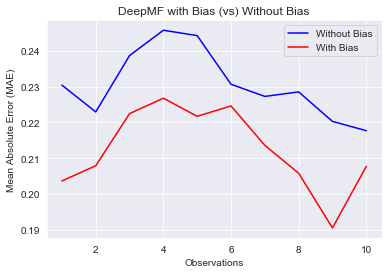

In [19]:
x=[1,2,3,4,5,6,7,8,9,10]
plt.plot(x,MAE_normalDMF,color="b",label='Without Bias')
plt.plot(x,MAE_biasDMF,color="r",label='With Bias')
plt.title("DeepMF with Bias (vs) Without Bias")
plt.xlabel("Observations")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.show()